In [3]:
try:
    import google.colab
    google.colab.drive.mount('/content/drive/')
    %cd ../content/drive/Othercomputers/Laptop/Flood_Detection
    !pip -q install pytorch_lightning
    !pip -q install torchview
except:
    pass

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: '../content/drive/Othercomputers/Laptop/Flood_Detection'
/content/drive/Othercomputers/Laptop/Flood_Detection
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 26.6 MB/s eta 0:00:00


In [4]:
import sys; sys.path.append('../../')
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
from torch.optim import lr_scheduler
import pytorch_lightning as pl
import albumentations as A
from torch.utils.data import TensorDataset
import torchmetrics
from torchmetrics import Metric
from pytorch_lightning.callbacks import EarlyStopping
from torchview import draw_graph
from DataPreparation.DataPreparation import read_data
import albumentations.pytorch as AP

### Initiate Model

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


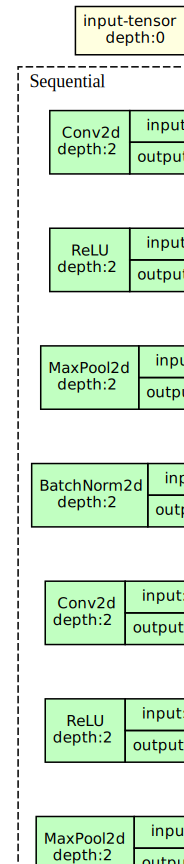

In [5]:
class ConvNet(pl.LightningModule):
    '''
    CNN Le Net Architecture Implementation
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.feature_extraction= nn.Sequential(
        
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1), 
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(6),
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Flatten()
        )
        self.feed_forward = nn.Sequential(
        nn.LazyLinear(120), nn.ReLU(),
        nn.Dropout(0.4),
        nn.LazyLinear(84), nn.ReLU(),
        nn.Linear(84, 1), nn.ReLU(),
        )  
        self.loss_fun = nn.BCEWithLogitsLoss()

        self.accuracy = torchmetrics.Accuracy(task="binary")
        self.F1 = torchmetrics.F1Score(task="binary", average="macro")
        

    def forward(self, x):
        '''
        Forward method to pass a given input batch to the model and return its predictions
        '''
        x = self.feature_extraction(x)
        x = self.feed_forward(x)
        return x

# The following function allows us to extend the class in other celss
def ConvNetClass(func):
    setattr(ConvNet, func.__name__, func)
    return func

# Graph of the model
model_graph = draw_graph(ConvNet(), input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

### Read & Preprocess Data

In [6]:
x_train_d, x_val_d, y_train_d, y_val_d = read_data(normalize=True, new_size=32, transpose=True, saved=False)

# check if x_train_d is a tensor

# Resplit below according to PyTorch standards
x_data = np.concatenate((x_train_d, x_val_d), axis=0)
y_data = np.concatenate((y_train_d, y_val_d), axis=0)

100%|██████████| 461/461 [01:32<00:00,  4.99it/s]


x_train shape:  (737, 3, 32, 32)
x_val shape:  (185, 3, 32, 32)


In [ ]:
@ConvNetClass
def prepare_data(self) :
    '''
    Converts x_data, y_data to torch tensors and splits the data into train and validation sets
    '''
    dataset = TensorDataset(torch.from_numpy(x_data).float(), torch.from_numpy(y_data).float())
    self.train_set, self.val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
    
@ConvNetClass
def train_dataloader(self):
    '''
    Gives PyTorch a way to extract training batches from the training set
    '''
    return torch.utils.data.DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=2)

@ConvNetClass
def val_dataloader(self):
    '''
    Gives PyTorch a way to extract validation batches from the validation set
    '''
    return torch.utils.data.DataLoader(self.val_set, batch_size=32, shuffle=False, num_workers=2)
        

### Training

In [ ]:
num_epochs = 30
lr = 0.01
@ConvNetClass
def configure_optimizers(self):
    '''
    Optimizer and Learning Scheduler for CNN training
    '''
    # PyTorch lightning takes a list of optimizers and a list of schedulers so 
    optimizers = [torch.optim.AdamW(self.parameters(), lr=lr), ]       
    schedulers = [lr_scheduler.OneCycleLR(optimizers[0], max_lr=lr, steps_per_epoch=len(self.train_dataloader()), epochs=num_epochs), ]
    return optimizers, schedulers

@ConvNetClass
def training_step(self, batch, batch_idx):
    '''
    At every epoch, for each batch in the training set, we want to:
    - Compute and return the loss so that the optimizer can update the weights
    - Compute training accuracy and loss for logging
    '''
    x, y = batch
    logits = self(x).flatten()
    loss = self.loss_fun(logits, y)
    F1 = self.F1(logits, y)    
    self.log("train_F1", F1, on_epoch=True, on_step=False, prog_bar=True)
    return loss

@ConvNetClass
def validation_step(self, batch, batch_idx):
    '''
    After every training epoch, a validation epoch runs. What to do for each batch in it:
    - Compute accuracy, validation loss and F1 score for logging
    '''
    x, y = batch
    logits = self(x).flatten()
    loss = self.loss_fun(logits, y)
    F1 = self.F1(logits, y)
    self.log("val_F1", F1, on_epoch=True, prog_bar=True)
    return loss


In [ ]:
model = ConvNet()
trainer = pl.Trainer(max_epochs=num_epochs, enable_checkpointing=False, logger=False, callbacks=[EarlyStopping(monitor="val_F1", patience=3, mode="max")])
trainer.fit(model)                      #fit performs the full optimization routine (train and validate each epoch)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type              | Params
---------------------------------------------------------
0 | feature_extraction | Sequential        | 2.9 K 
1 | feed_forward       | Sequential        | 85    
2 | loss_fun           | BCEWithLogitsLoss | 0     
3 | accuracy           | BinaryAccuracy    | 0     
4 | F1                 | BinaryF1Score 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]